In [ ]:
# https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-instacart

In [ ]:
# Objective:
# The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.
# For each user, 4 and 100 of their orders are given, with the sequence of products purchased in each order    

## 1. Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
order_products_train_df = pd.read_csv("E:/Kaggle_Practice/Instacart_Market_Basket_Analysis/order_products__train.csv")
order_products_prior_df = pd.read_csv("E:/Kaggle_Practice/Instacart_Market_Basket_Analysis/order_products__prior.csv")
orders_df = pd.read_csv("E:/Kaggle_Practice/Instacart_Market_Basket_Analysis/orders.csv")
products_df = pd.read_csv("E:/Kaggle_Practice/Instacart_Market_Basket_Analysis/products.csv")
aisles_df = pd.read_csv("E:/Kaggle_Practice/Instacart_Market_Basket_Analysis/aisles.csv")
departments_df = pd.read_csv("E:/Kaggle_Practice/Instacart_Market_Basket_Analysis/departments.csv")

In [4]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [10]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [13]:
products_df.groupby('department_id')['aisle_id'].value_counts(ascending=False)

department_id  aisle_id
1              37          1091
               38           880
               129          386
               116          361
               79           335
                           ... 
20             67           327
               13           317
               14           159
               1            146
21             100         1258
Name: aisle_id, Length: 134, dtype: int64

In [14]:
departments_df.nunique()

department_id    21
department       21
dtype: int64

In [15]:
aisles_df.nunique()

aisle_id    134
aisle       134
dtype: int64

In [ ]:
# As we could see, orders.csv has all the information about the given order id like the user who has purchased the order, when was it purchased, days since prior order and so on.

# The columns present in order_products_train and order_products_prior are same. Then what is the difference between these files.?

# As mentioned earlier, in this dataset, 4 to 100 orders of a customer are given (we will look at this later) and we need to predict the products that will be re-ordered. So the last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_products_prior file. We can also note that there is a column in orders.csv file called eval_set which tells us as to which of the three datasets (prior, train or test) the given row goes to.

# Order_products*csv file has more detailed information about the products that been bought in the given order along with the re-ordered status.

#### Let us first get the count of rows in each of the three sets

C:\Users\katenam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


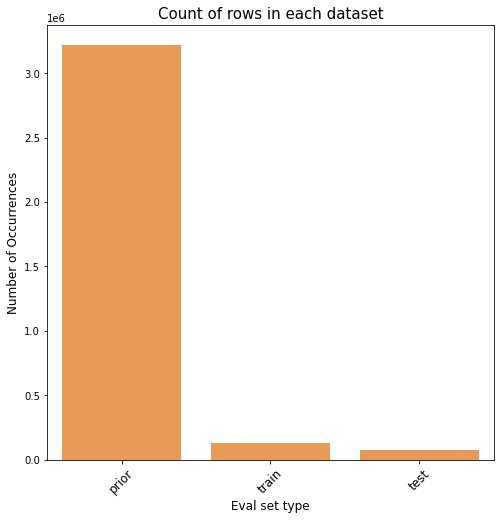

In [20]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(8,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation=45,fontsize=12)
plt.show()

In [21]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

#### So there are 206,209 customers in total. Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.

#### Now let us validate the claim that 4 to 100 orders of a customer are given.

C:\Users\katenam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


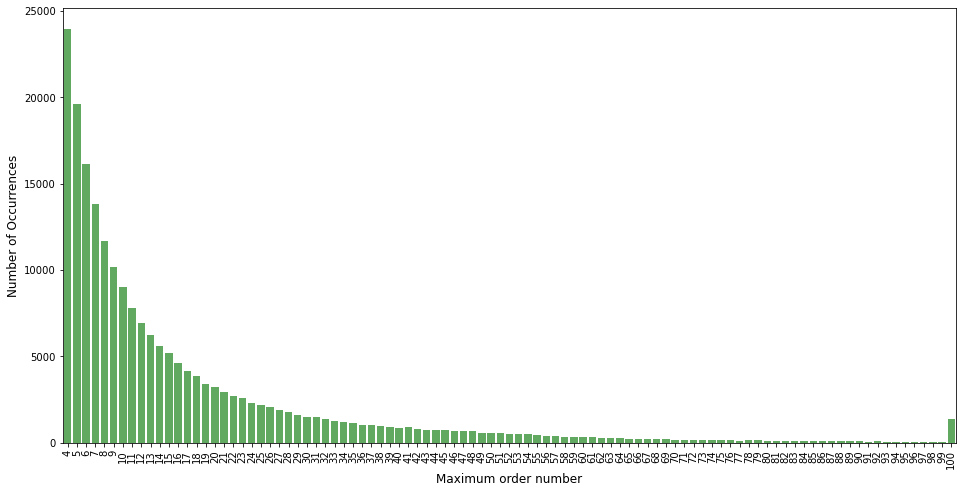

In [23]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(16,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()